In [4]:
import os
import sys

import numpy as np
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import colors
from hydra import initialize, compose
import pickle
from glob import glob
from pprint import pprint
from tqdm import tqdm
import galsim
from copy import deepcopy
import corner

# set paths to various directories based on the machine this code is being executed on
try:
    with initialize(version_base=None, config_path='config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']
except:
    with initialize(version_base=None, config_path='../../config'):  
        config = compose(config_name='config.yaml')  # overrides=['machine=uzay']

array_dir, data_dir, figure_dir, pickle_dir, repo_dir  = config.machine.array_dir, config.machine.data_dir, config.machine.figure_dir, config.machine.pickle_dir, config.machine.repo_dir

# enable use of local modules
if repo_dir not in sys.path:
    sys.path.append(repo_dir)

# set matplotlib style
plt.style.use(f'{repo_dir}/mejiro/mplstyle/science.mplstyle')

from mejiro.lenses.test import SampleStrongLens
from mejiro.plots import diagnostic_plot, plot, plot_util, overplot
from mejiro.analysis import stats
from mejiro.utils import util
from mejiro.helpers import gs
from mejiro.instruments.roman import Roman
from mejiro.synthetic_image import SyntheticImage
from mejiro.exposure import Exposure

In [3]:
lens = SampleStrongLens()
roman = Roman()

band = 'F087'
scene_size = 5.61  # arcsec
oversample = 1
sca = 2
sca_position = (1533, 1533)
exposure_time = 146

realization = lens.generate_cdm_subhalos()
halos = [halo for halo in realization.halos]
concentrations = [halo.c for halo in halos]
masses = [halo.mass for halo in halos]

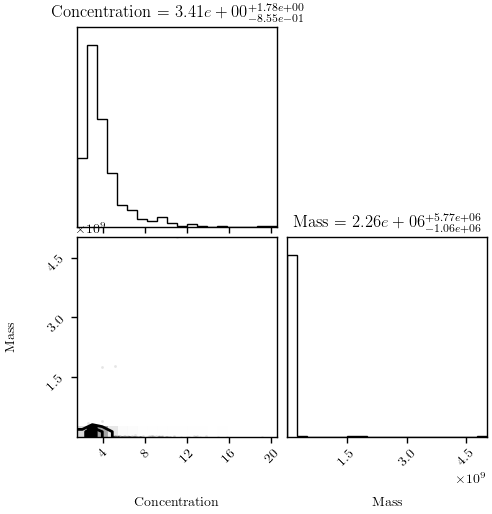

In [5]:
data = np.column_stack((concentrations, masses))

fig = corner.corner(data, labels=['Concentration', 'Mass'], show_titles=True, title_fmt='.2e', title_kwargs={"fontsize": 12})

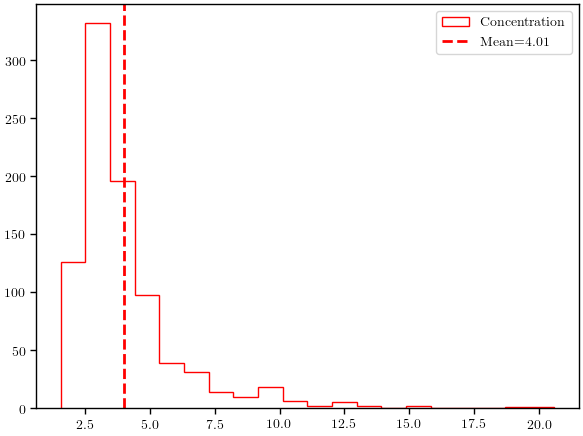

In [7]:
plt.hist(concentrations, bins=20, histtype='step', color='r', label='Concentration')
plt.axvline(np.mean(concentrations), color='r', linestyle='--', label=f'Mean={np.mean(concentrations):.2f}')
plt.legend()
plt.show()

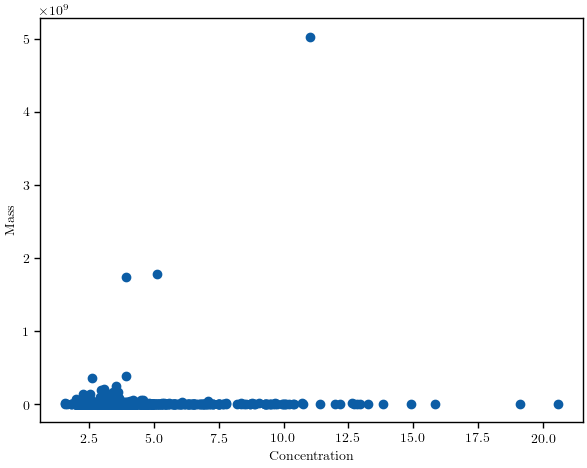

In [9]:
plt.scatter(concentrations, masses)
plt.xlabel('Concentration')
plt.ylabel('Mass')
plt.show()